In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))

100%|██████████| 170M/170M [03:53<00:00, 731kB/s]


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [ ]:
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
accuracy_graph = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    accuracy_graph.append(accuracy)


    print(f"Эпоха [{epoch+1}/{num_epochs}] | Потеря: {epoch_loss:.4f} | Точность: {accuracy:.2f}%")


Эпоха [1/10] | Потеря: 1.4599 | Точность: 49.08%
Эпоха [2/10] | Потеря: 1.1115 | Точность: 61.10%
Эпоха [3/10] | Потеря: 0.9906 | Точность: 65.38%
Эпоха [4/10] | Потеря: 0.9254 | Точность: 67.83%
Эпоха [5/10] | Потеря: 0.8806 | Точность: 69.51%
Эпоха [6/10] | Потеря: 0.8444 | Точность: 70.56%
Эпоха [7/10] | Потеря: 0.8160 | Точность: 71.95%
Эпоха [8/10] | Потеря: 0.7918 | Точность: 72.63%
Эпоха [9/10] | Потеря: 0.7690 | Точность: 73.41%
Эпоха [10/10] | Потеря: 0.7493 | Точность: 74.04%


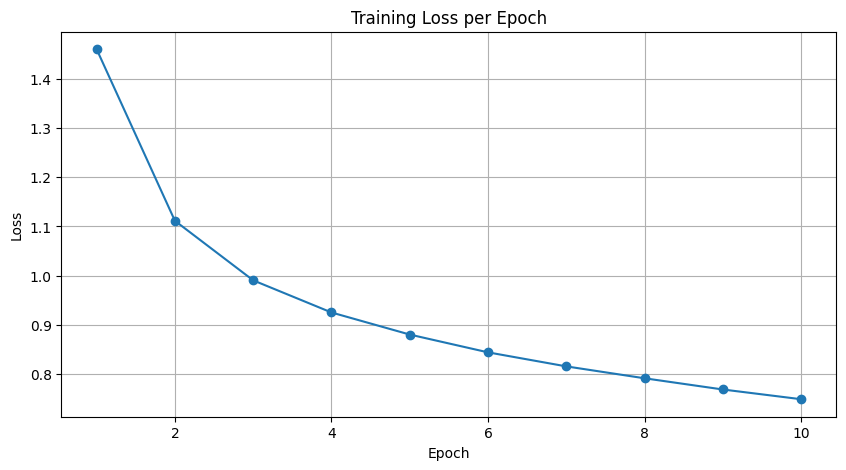

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

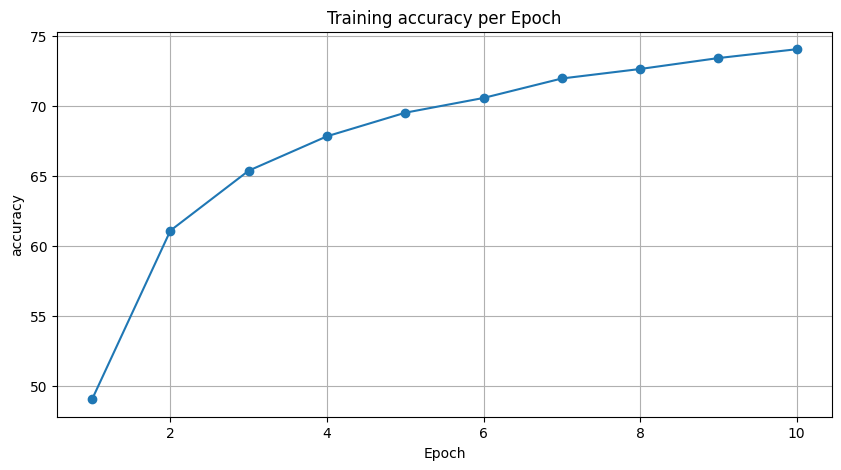

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracy_graph, marker='o')
plt.title('Training accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.7516, Test Accuracy: 74.07%


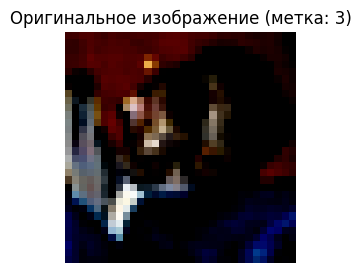

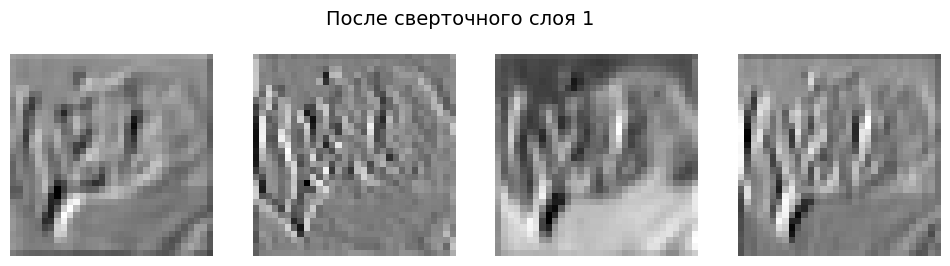

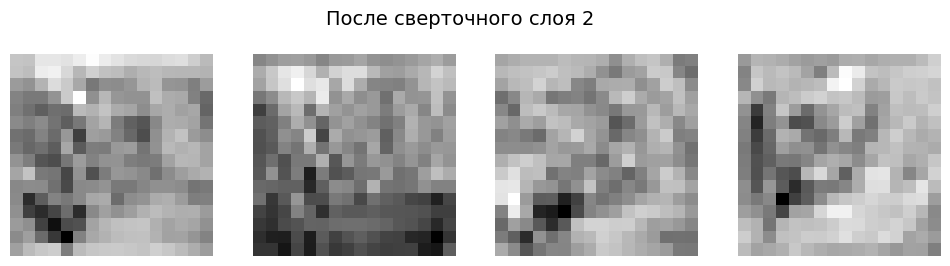

Истинная метка: 3
Предсказание модели: 3


In [ ]:
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)
label = labels[0].item()

plt.figure(figsize=(3, 3))
plt.imshow(images[0].permute(1, 2, 0).cpu().clip(0, 1))
plt.title(f"Оригинальное изображение (метка: {label})")
plt.axis('off')
plt.show()

activation_maps = []
x = image

for layer in [model.conv1, model.bn1, model.pool,
              model.conv2, model.bn2, model.pool]:
    x = layer(x)
    if isinstance(layer, torch.nn.Conv2d):
        activation_maps.append(x)

for i, fmap in enumerate(activation_maps):
    fmap = fmap.detach().cpu()
    num_features = min(4, fmap.shape[1])
    fig, axes = plt.subplots(1, num_features, figsize=(12, 3))
    fig.suptitle(f"После сверточного слоя {i+1}", fontsize=14)

    for j in range(num_features):
        axes[j].imshow(fmap[0, j, :, :], cmap='gray')
        axes[j].axis('off')

    plt.show()

model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

print(f"Истинная метка: {label}")
print(f"Предсказание модели: {predicted.item()}")
